In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2

In [2]:
# 1. Загрузка метаданных
train_csv_path = 'C:/Ester/final/extracted_dataset/Train.csv'
test_csv_path = 'C:/Ester/final/extracted_dataset/Test.csv'
meta_csv_path = 'C:/Ester/final/extracted_dataset/Meta.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
meta_df = pd.read_csv(meta_csv_path)

# Проверим структуру данных
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Number of classes:", len(train_df['ClassId'].unique()))

Train data shape: (39209, 8)
Test data shape: (12630, 8)
Number of classes: 43


In [4]:
# 2. Функция для загрузки изображений
def load_images(data_df, base_path):
    images = []
    labels = []
    
    for idx, row in data_df.iterrows():
        img_path = os.path.join(base_path, row['Path'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = cv2.resize(image, (32, 32))  
        images.append(image)
        labels.append(row['ClassId'])
    
    return np.array(images), np.array(labels)

# Загрузка тренировочных и тестовых изображений
train_images, train_labels = load_images(train_df, 'C:/Ester/final/extracted_dataset/')
test_images, test_labels = load_images(test_df, 'C:/Ester/final/extracted_dataset/')

In [5]:
# 3. Нормализация и преобразование меток
train_images = train_images / 255.0
test_images = test_images / 255.0

# One-hot encoding для меток
num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [6]:
# 4. Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {test_images.shape}, {test_labels.shape}")


Train: (31367, 32, 32, 3), (31367, 43)
Validation: (7842, 32, 32, 3), (7842, 43)
Test: (12630, 32, 32, 3), (12630, 43)


In [7]:
# 5. Создание генераторов данных с аугментацией
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  

# Подготовка генераторов
batch_size = 64

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

Примеры аугментированных изображений:


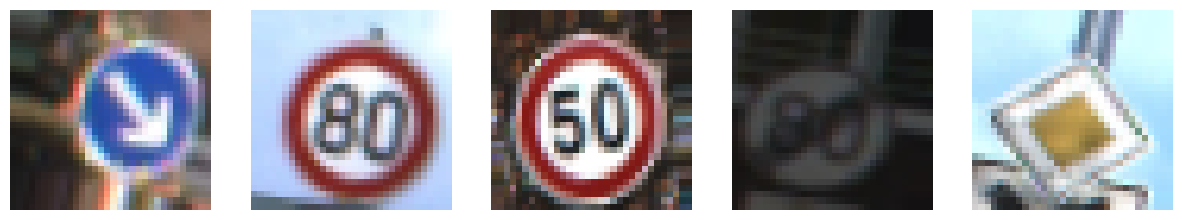

In [8]:
# 6 Визуализация примеров с аугментацией
def plot_augmented_images(generator, n_images=5):
    fig, axes = plt.subplots(1, n_images, figsize=(15, 3))
    for i in range(n_images):
        batch = next(generator)
        image = batch[0][0]
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

print("Примеры аугментированных изображений:")
plot_augmented_images(train_generator)

# Сохранение подготовленных данных для последующего использования
np.savez('prepared_data.npz', 
         X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val,
         X_test=test_images, y_test=test_labels)

In [9]:
!pip install seaborn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, Layout
from IPython.display import display, clear_output
import ipywidgets as widgets

In [10]:
# 7. Загрузка подготовленных данных
data = np.load('prepared_data.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

In [11]:
# 8. Создание модели CNN с регуляризацией
def create_model(input_shape=(32, 32, 3), num_classes=43):
    model = Sequential([
        # Блок 1
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Блок 2
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Блок 3
        Conv2D(128, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Полносвязные слои
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

model.summary()


C:\Ester\WORK\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 825,419 (3.15 MB)

 Trainable params: 824,011 (3.14 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [12]:
# 9. Коллбеки для обучения
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [13]:
# 10. Обучение модели
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50


C:\Ester\WORK\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


490/490 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.2464 - loss: 3.9463 - precision: 0.4684 - recall: 0.1313 - val_accuracy: 0.7211 - val_loss: 1.6683 - val_precision: 0.8848 - val_recall: 0.5880 - learning_rate: 0.0010
Epoch 2/50
  1/490 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.6406 - loss: 1.9313 - precision: 0.8974 - recall: 0.5469

C:\Ester\WORK\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 1.9313 - precision: 0.8974 - recall: 0.5469 - val_accuracy: 0.7167 - val_loss: 1.6700 - val_precision: 0.8776 - val_recall: 0.5894 - learning_rate: 0.0010
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.7561 - loss: 1.5363 - precision: 0.8575 - recall: 0.6583 - val_accuracy: 0.9602 - val_loss: 0.8064 - val_precision: 0.9712 - val_recall: 0.9499 - learning_rate: 0.0010
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.8820 - precision: 0.9677 - recall: 0.9375 - val_accuracy: 0.9591 - val_loss: 0.8090 - val_precision: 0.9703 - val_recall: 0.9483 - learning_rate: 0.0010
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9050 - loss: 0.9544 - precision: 0.9374 - recall: 0.8743 - val_accuracy: 0.9758 - val_loss: 0.6496 - val_precision: 0.9812 - val_recall: 0.9700 - learning_rate: 0.0010
Epoch 6/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 

Оценка на валидационной выборке:
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


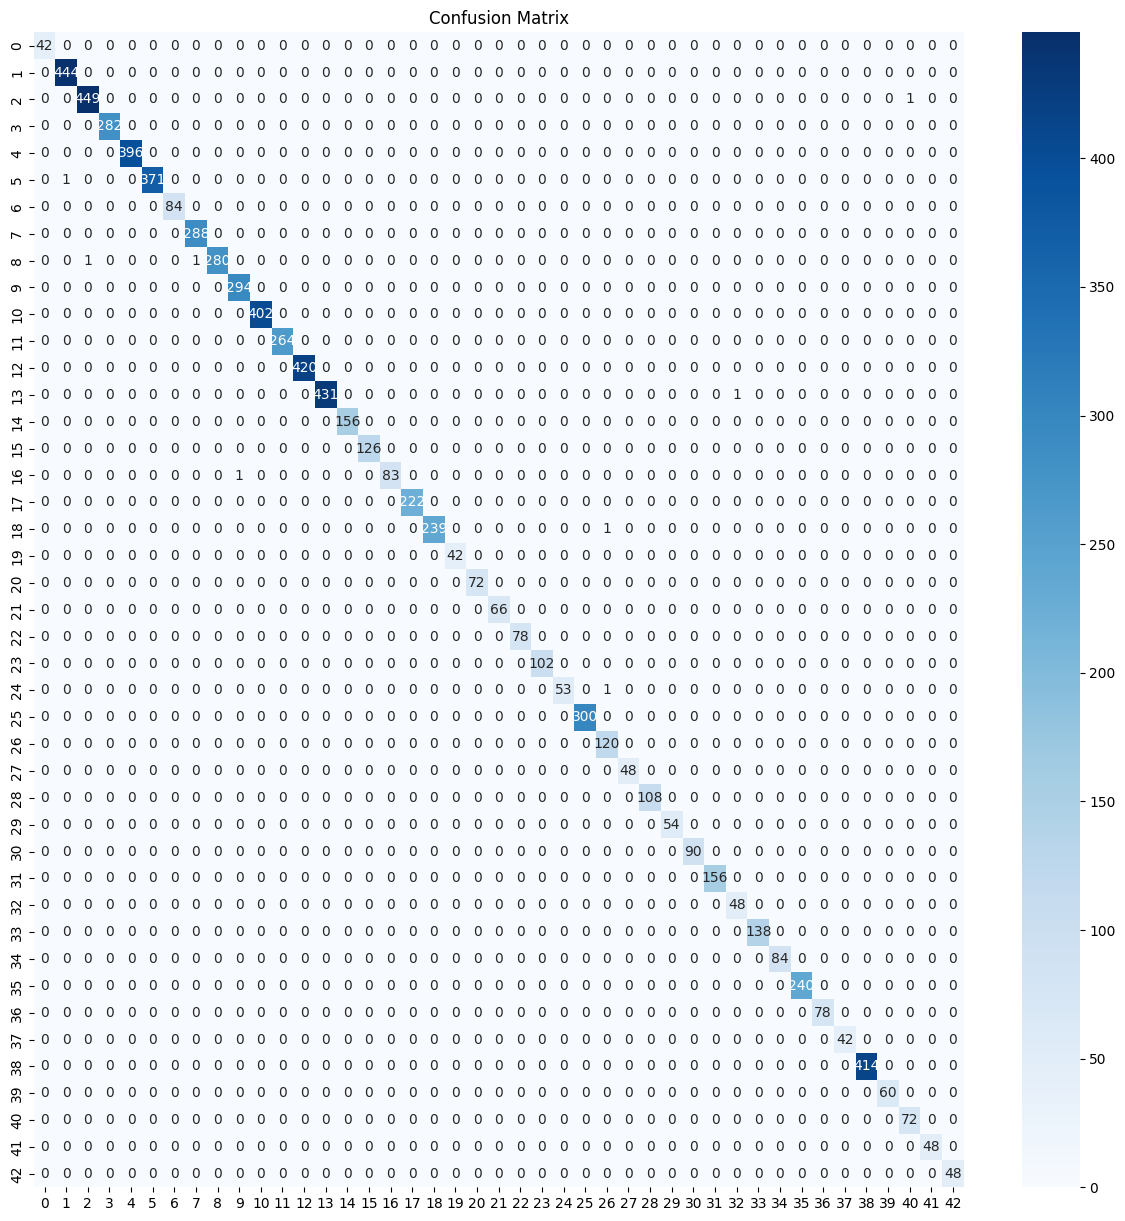

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       444
           2       1.00      1.00      1.00       450
           3       1.00      1.00      1.00       282
           4       1.00      1.00      1.00       396
           5       1.00      1.00      1.00       372
           6       1.00      1.00      1.00        84
           7       1.00      1.00      1.00       288
           8       1.00      0.99      1.00       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       1.00      1.00      1.00       126
          16       1.00      0.99      0.99        84
          17       1.00    

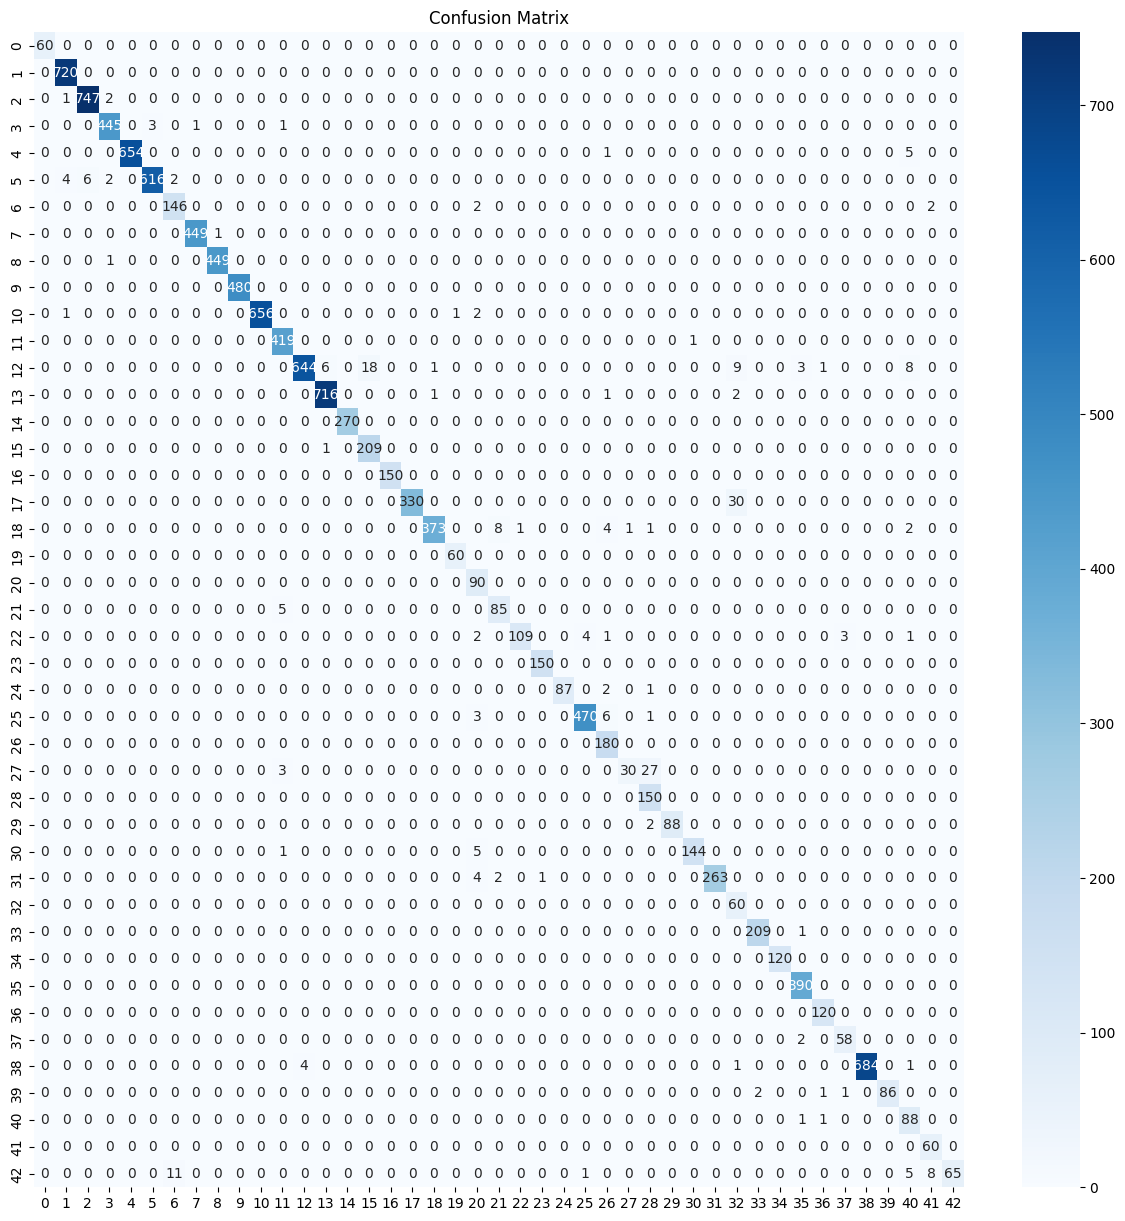

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       0.99      0.99      0.99       450
           4       1.00      0.99      1.00       660
           5       1.00      0.98      0.99       630
           6       0.92      0.97      0.94       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       0.98      1.00      0.99       420
          12       0.99      0.93      0.96       690
          13       0.99      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.92      1.00      0.96       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [14]:
# 11. Оценка модели
def evaluate_model(model, X_test, y_test):
    # Оценка на тестовых данных
    test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
    
    # Прогнозы для дополнительных метрик
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Матрица ошибок
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Отчёт о классификации
    print(classification_report(y_true_classes, y_pred_classes))
    
    # Вывод основных метрик
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    
    return test_acc, test_precision, test_recall

print("Оценка на валидационной выборке:")
val_acc, val_precision, val_recall = evaluate_model(model, X_val, y_val)

print("\nОценка на тестовой выборке:")
test_acc, test_precision, test_recall = evaluate_model(model, X_test, y_test)


Оценка на зашумленных данных:
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


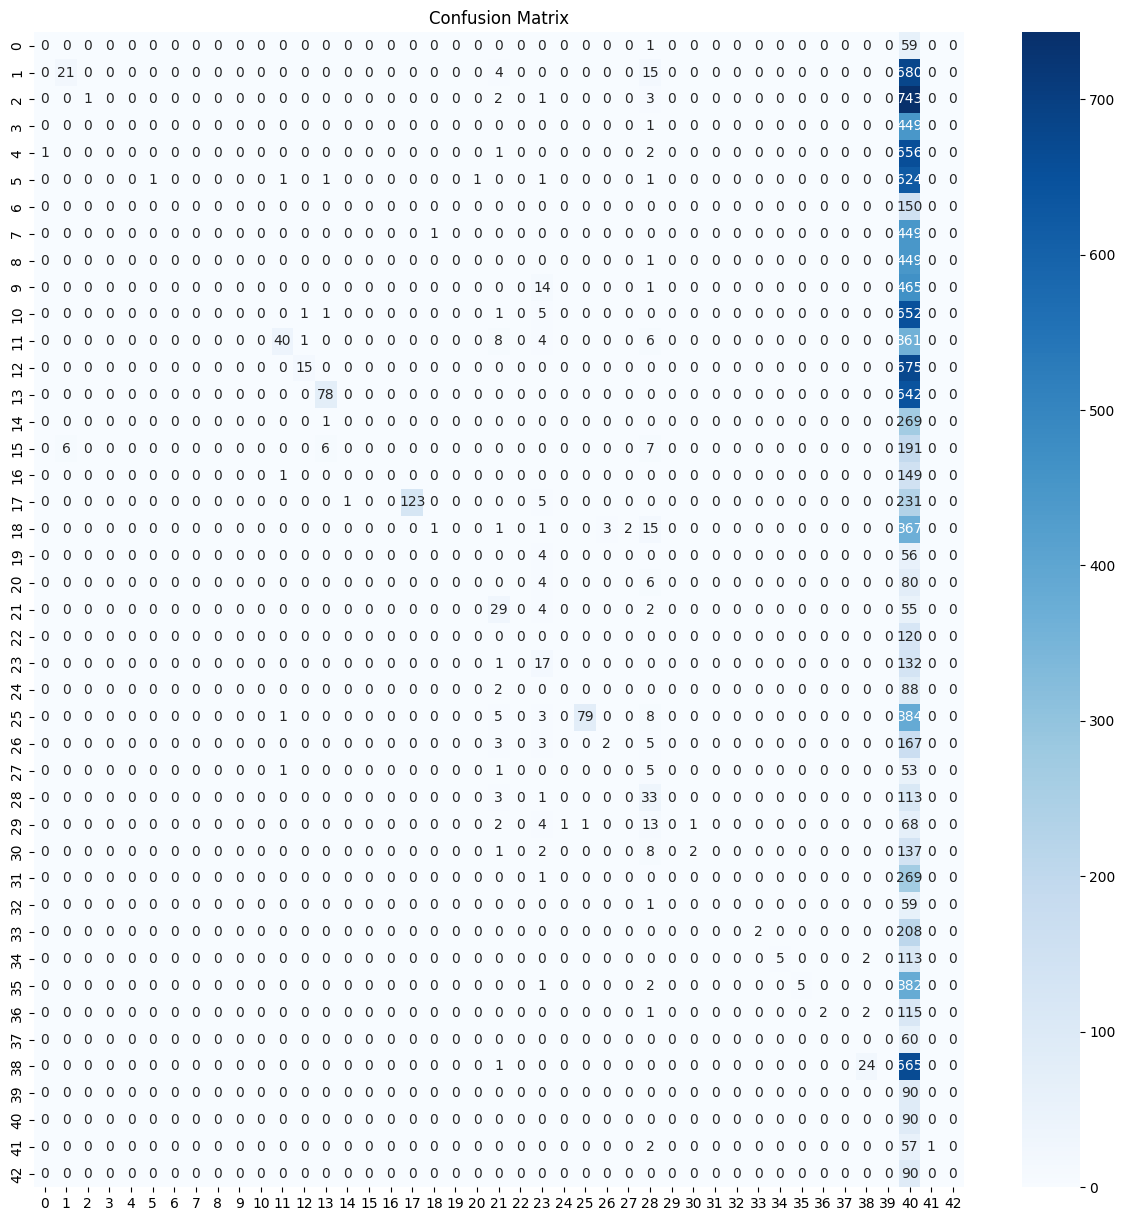

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.78      0.03      0.06       720
           2       1.00      0.00      0.00       750
           3       0.00      0.00      0.00       450
           4       0.00      0.00      0.00       660
           5       1.00      0.00      0.00       630
           6       0.00      0.00      0.00       150
           7       0.00      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.00      0.00      0.00       660
          11       0.91      0.10      0.17       420
          12       0.88      0.02      0.04       690
          13       0.90      0.11      0.19       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16       0.00      0.00      0.00       150
          17       1.00    

C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [15]:
# 12. Оценка на зашумленных данных
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

X_test_noisy = add_noise(X_test)
print("\nОценка на зашумленных данных:")
noisy_acc, noisy_precision, noisy_recall = evaluate_model(model, X_test_noisy, y_test)


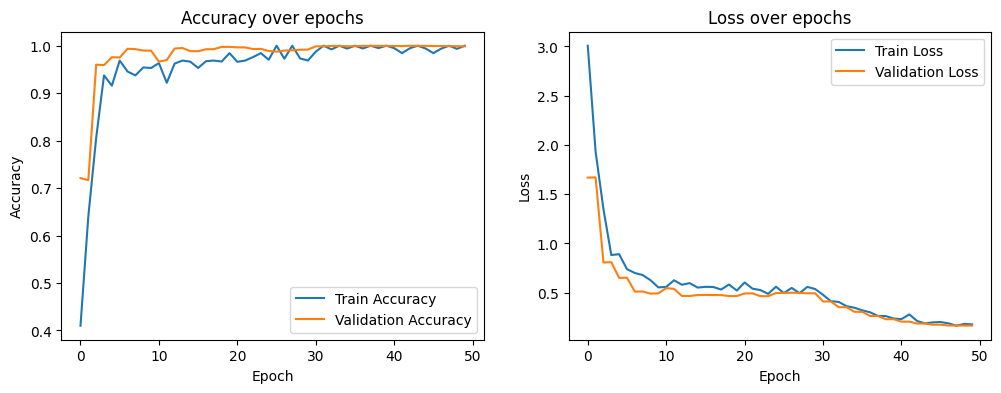

In [16]:
# 13. Визуализация обучения
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()

plot_training_history(history)

In [17]:
# 14. Сохранение модели
model.save('traffic_sign_model.keras')


In [22]:
# 15. Повторная аугментация для улучшения качества модели на зашумленных данных
#  Упрощенная и надежная функция аугментации
def custom_augmentation(image):
    # Работаем с float32 в диапазоне [0,1]
    image = image.copy()
    
    # Гауссовский шум (работаем напрямую с float)
    if np.random.rand() > 0.5:
        noise = np.random.normal(loc=0.0, scale=np.random.uniform(0.01, 0.05), size=image.shape)
        image = image + noise
        image = np.clip(image, 0., 1.)
    
    # Размытие (через scipy чтобы избежать проблем с типами)
    if np.random.rand() > 0.5:
        from scipy.ndimage import gaussian_filter
        image = gaussian_filter(image, sigma=np.random.uniform(0.5, 1.0))
    
    # Изменение яркости/контраста
    if np.random.rand() > 0.5:
        alpha = np.random.uniform(0.8, 1.2)  # Контраст
        beta = np.random.uniform(-0.1, 0.1)  # Яркость
        image = image * alpha + beta
        image = np.clip(image, 0., 1.)
    
    # Имитация дождя (реализация без OpenCV)
    if np.random.rand() > 0.8:
        h, w = image.shape[:2]
        n_lines = np.random.randint(5, 15)
        for _ in range(n_lines):
            x = np.random.randint(0, w)
            length = np.random.randint(h//3, h)
            y_start = np.random.randint(0, h-length)
            thickness = np.random.randint(1, 3)
            color = np.random.uniform(0.7, 0.9)
            
            # Рисуем линию вручную
            y_end = min(y_start + length, h-1)
            image[y_start:y_end, x:x+thickness] = color
    
    return image

In [23]:
# 16. Создаем улучшенный генератор данных
augmented_datagen = ImageDataGenerator(
    preprocessing_function=custom_augmentation,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode='nearest'
)

In [24]:
 # 17. Подготовка генераторов
batch_size = 64

train_generator = augmented_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [28]:
def create_improved_model(input_shape=(32, 32, 3), num_classes=43):
    model = Sequential([
        # Блок 1
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Блок 2
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Блок 3
        Conv2D(128, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Полносвязные слои
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.002)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

In [29]:
improved_model = create_improved_model()
improved_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy', 
                               tf.keras.metrics.Precision(name='precision'),
                               tf.keras.metrics.Recall(name='recall')])

# Выведем архитектуру для проверки
improved_model.summary()

C:\Ester\WORK\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 853,323 (3.26 MB)

 Trainable params: 851,659 (3.25 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [30]:
# 18. Определяем коллбеки 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


In [31]:
# 19. Обучение модели
batch_size = 64 

try:
    improved_history = improved_model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // batch_size,
        epochs=50,
        validation_data=val_generator,
        validation_steps=len(X_val) // batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
except Exception as e:
    print("Ошибка при обучении:", e)
    print("Проверьте, что:")
    print("1. train_generator и val_generator существуют")
    print("2. X_train, X_val загружены")
    print("3. batch_size определен")

Epoch 1/50


C:\Ester\WORK\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


490/490 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.0519 - loss: 5.9085 - precision: 0.0514 - recall: 0.0025 - val_accuracy: 0.1473 - val_loss: 4.3824 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
  1/490 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.0781 - loss: 4.6131 - precision: 0.0000e+00 - recall: 0.0000e+00

C:\Ester\WORK\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0781 - loss: 4.6131 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1570 - val_loss: 4.4484 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.1861 - loss: 4.1432 - precision: 0.4257 - recall: 0.0328 - val_accuracy: 0.4557 - val_loss: 2.5692 - val_precision: 0.9482 - val_recall: 0.2180 - learning_rate: 0.0010
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3906 - loss: 2.9339 - precision: 0.7857 - recall: 0.1719 - val_accuracy: 0.4558 - val_loss: 2.5653 - val_precision: 0.9406 - val_recall: 0.2189 - learning_rate: 0.0010
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.3715 - loss: 2.8469 - precision: 0.8030 - recall: 0.1770 - val_accuracy: 0.5451 - val_loss: 2.1128 - val_precision: 0.8599 - val_recall: 0.3121 - learning_rate: 0.0010
Epoch 6/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - a

In [34]:
# 5. Сохранение улучшенной модели
improved_model.save('improved_traffic_sign_model.keras')

In [35]:
# 1. Функция для добавления шума 
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy


In [36]:
# 20. Создаем зашумленные тестовые данные
X_test_noisy = add_noise(X_test, noise_factor=0.5)


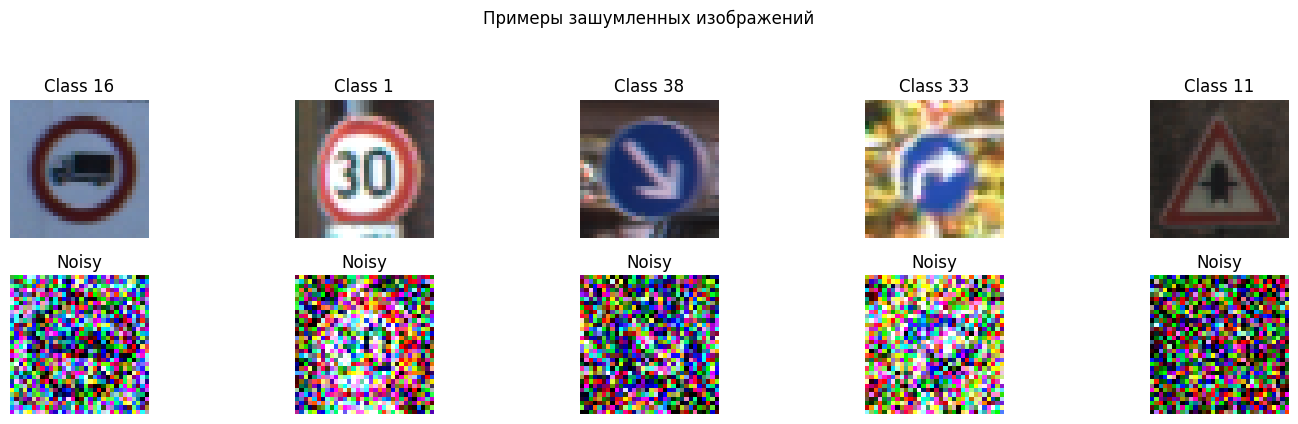

In [37]:
# 21. Визуализация примеров до/после добавления шума
def plot_noisy_examples(clean, noisy, n_examples=5):
    plt.figure(figsize=(15, 4))
    for i in range(n_examples):
        plt.subplot(2, n_examples, i+1)
        plt.imshow(clean[i])
        plt.title(f"Class {np.argmax(y_test[i])}")
        plt.axis('off')
        
        plt.subplot(2, n_examples, i+n_examples+1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')
    plt.suptitle("Примеры зашумленных изображений", y=1.05)
    plt.tight_layout()
    plt.show()

plot_noisy_examples(X_test, X_test_noisy)


Оценка улучшенной модели на зашумленных данных (noise_factor=0.5):
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


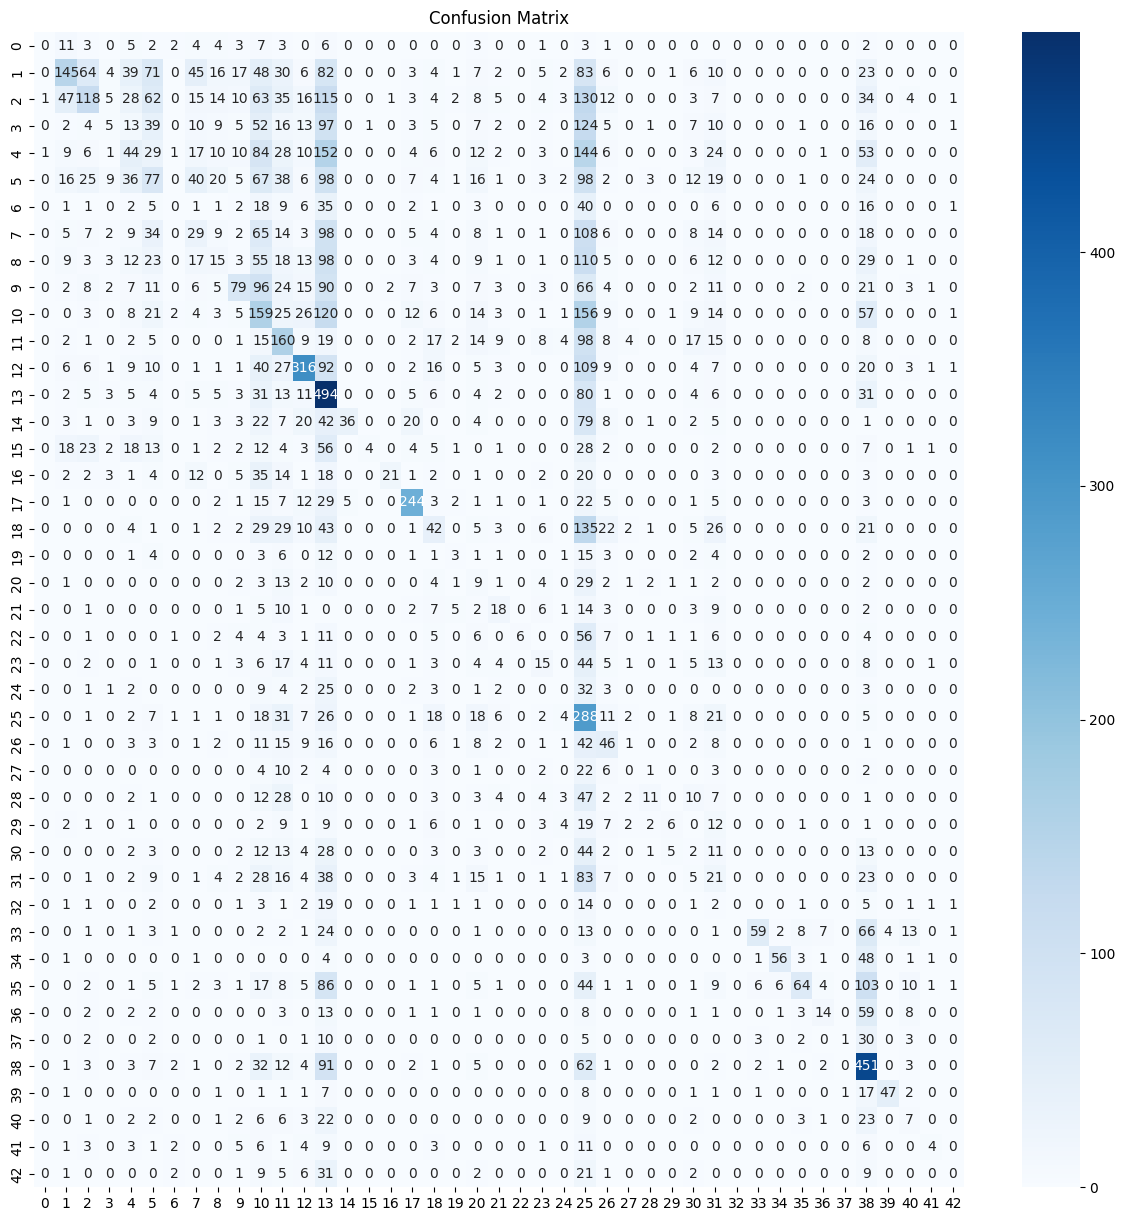

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.50      0.20      0.29       720
           2       0.39      0.16      0.22       750
           3       0.12      0.01      0.02       450
           4       0.16      0.07      0.09       660
           5       0.16      0.12      0.14       630
           6       0.00      0.00      0.00       150
           7       0.13      0.06      0.09       450
           8       0.11      0.03      0.05       450
           9       0.43      0.16      0.24       480
          10       0.14      0.24      0.18       660
          11       0.22      0.38      0.28       420
          12       0.56      0.46      0.51       690
          13       0.21      0.69      0.33       720
          14       0.88      0.13      0.23       270
          15       0.80      0.02      0.04       210
          16       0.88      0.14      0.24       150
          17       0.71    

C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [38]:
# 22. Оценка модели на зашумленных данных
print("\nОценка улучшенной модели на зашумленных данных (noise_factor=0.5):")
noisy_acc, noisy_precision, noisy_recall = evaluate_model(improved_model, X_test_noisy, y_test)


Сравнение метрик:
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


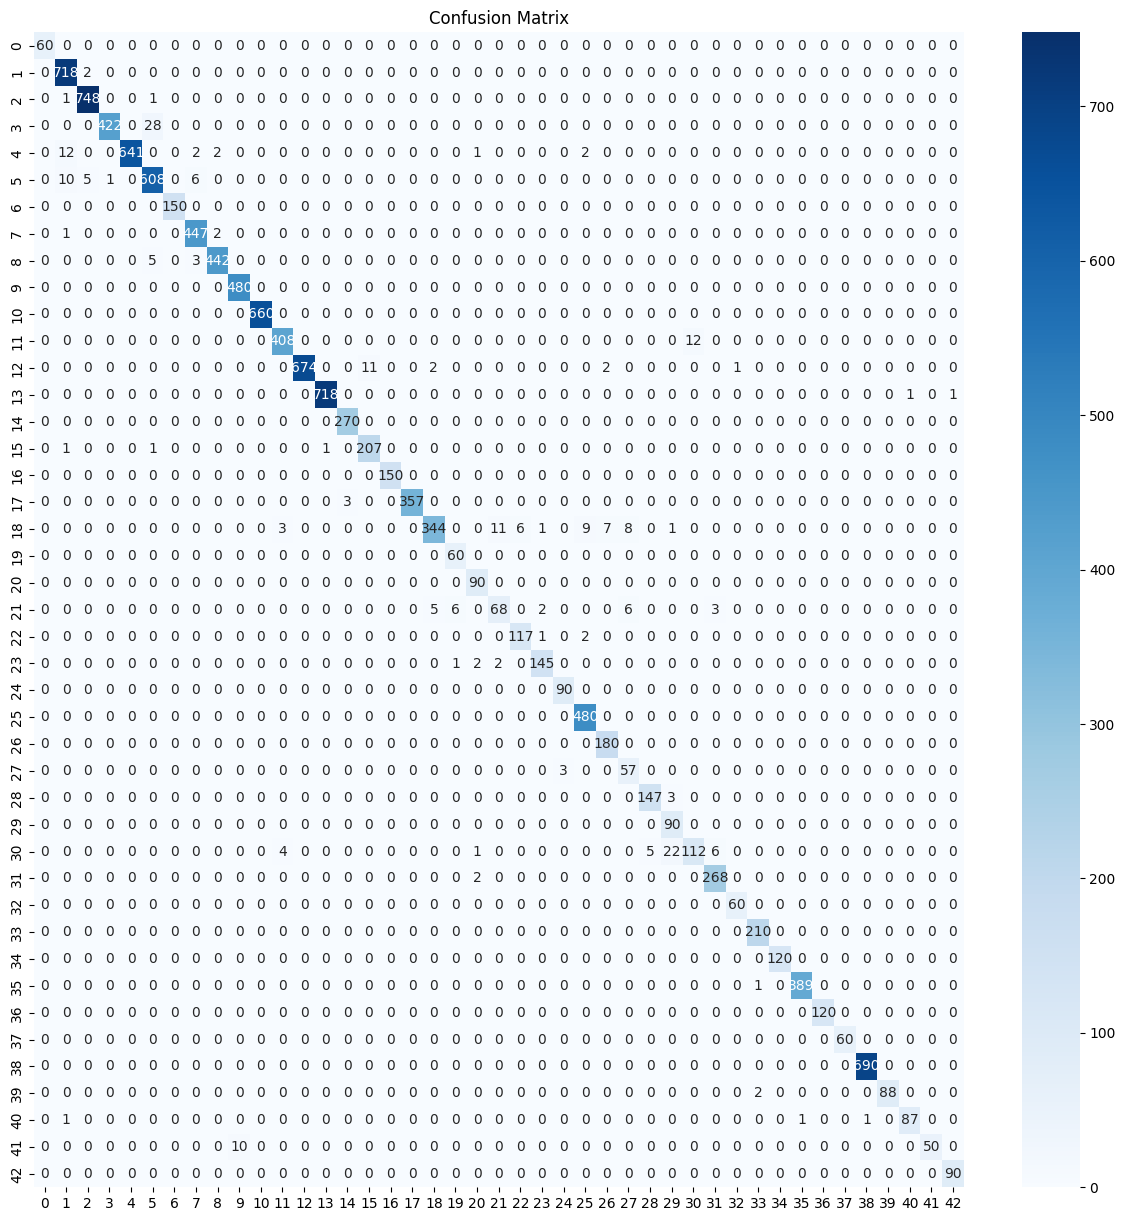

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.97      1.00      0.98       720
           2       0.99      1.00      0.99       750
           3       1.00      0.94      0.97       450
           4       1.00      0.97      0.99       660
           5       0.95      0.97      0.96       630
           6       1.00      1.00      1.00       150
           7       0.98      0.99      0.98       450
           8       0.99      0.98      0.99       450
           9       0.98      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.98      0.97      0.98       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.95      0.99      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

,Метрика,Чистые данные,Зашумленные данные,Разница (%)
0,Accuracy,97.96%,24.67%,74.8%
1,Precision,98.43%,58.00%,41.1%
2,Recall,97.77%,16.67%,82.9%


In [39]:
# 23. Сравнение с чистыми данными
print("\nСравнение метрик:")
clean_acc, clean_precision, clean_recall = evaluate_model(improved_model, X_test, y_test)

# Создаем таблицу сравнения
metrics_comparison = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall'],
    'Чистые данные': [clean_acc, clean_precision, clean_recall],
    'Зашумленные данные': [noisy_acc, noisy_precision, noisy_recall],
    'Разница (%)': [
        (clean_acc - noisy_acc)/clean_acc*100,
        (clean_precision - noisy_precision)/clean_precision*100,
        (clean_recall - noisy_recall)/clean_recall*100
    ]
})

# Форматируем вывод
metrics_comparison['Чистые данные'] = metrics_comparison['Чистые данные'].apply(lambda x: f"{x:.2%}")
metrics_comparison['Зашумленные данные'] = metrics_comparison['Зашумленные данные'].apply(lambda x: f"{x:.2%}")
metrics_comparison['Разница (%)'] = metrics_comparison['Разница (%)'].apply(lambda x: f"{x:.1f}%")

display(metrics_comparison)



Анализ устойчивости к разным уровням шума:
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


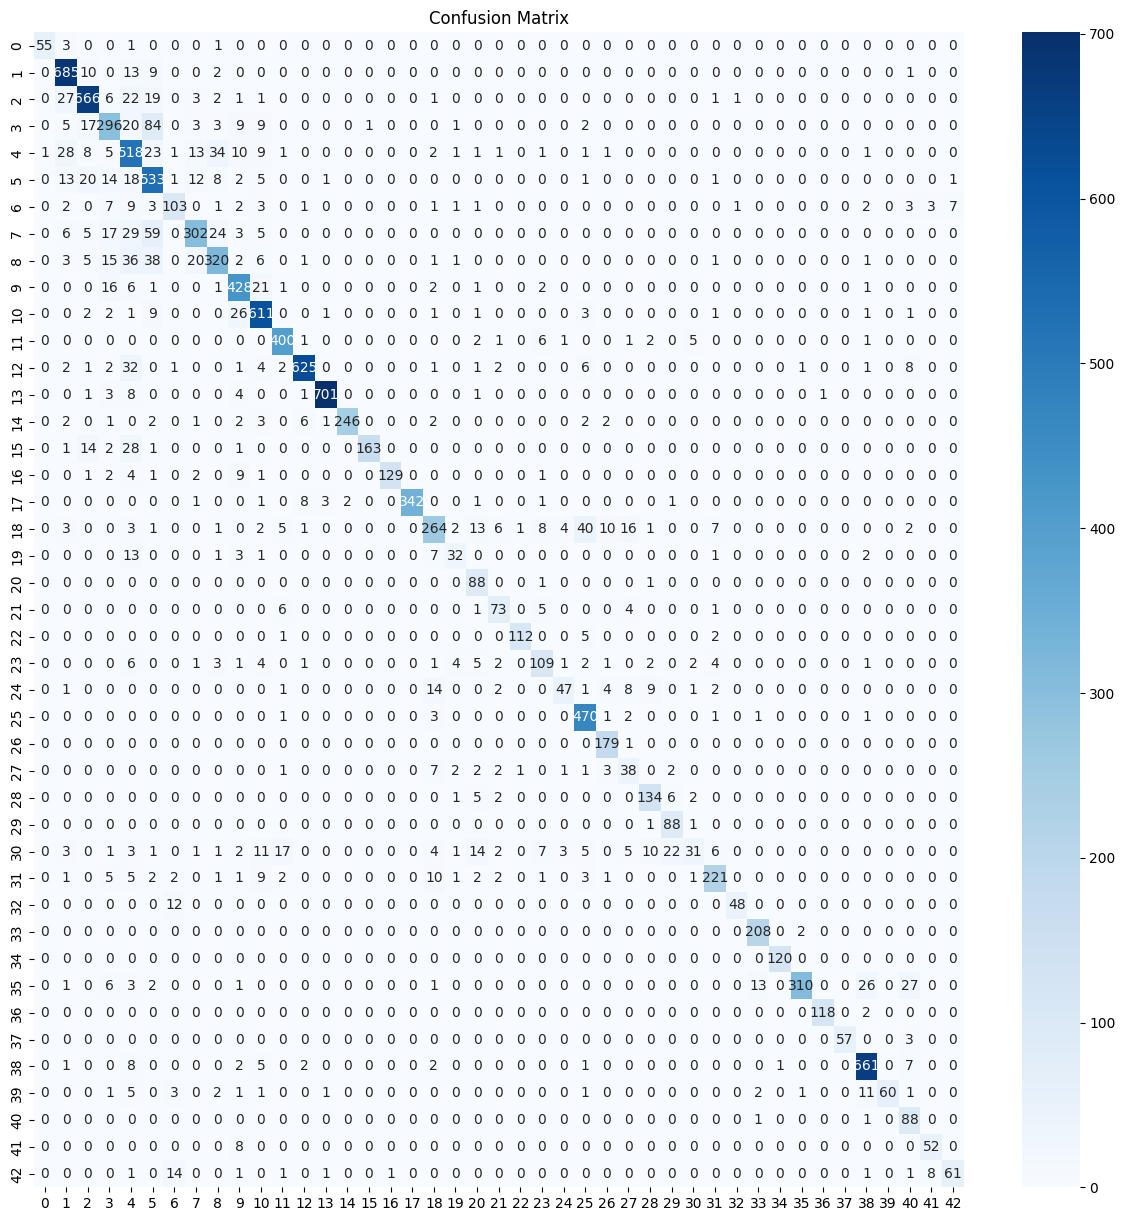

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        60
           1       0.87      0.95      0.91       720
           2       0.89      0.89      0.89       750
           3       0.74      0.66      0.70       450
           4       0.65      0.78      0.71       660
           5       0.68      0.85      0.75       630
           6       0.75      0.69      0.72       150
           7       0.84      0.67      0.75       450
           8       0.79      0.71      0.75       450
           9       0.82      0.89      0.86       480
          10       0.86      0.93      0.89       660
          11       0.91      0.95      0.93       420
          12       0.97      0.91      0.93       690
          13       0.99      0.97      0.98       720
          14       0.99      0.91      0.95       270
          15       0.99      0.78      0.87       210
          16       0.99      0.86      0.92       150
          17       1.00    

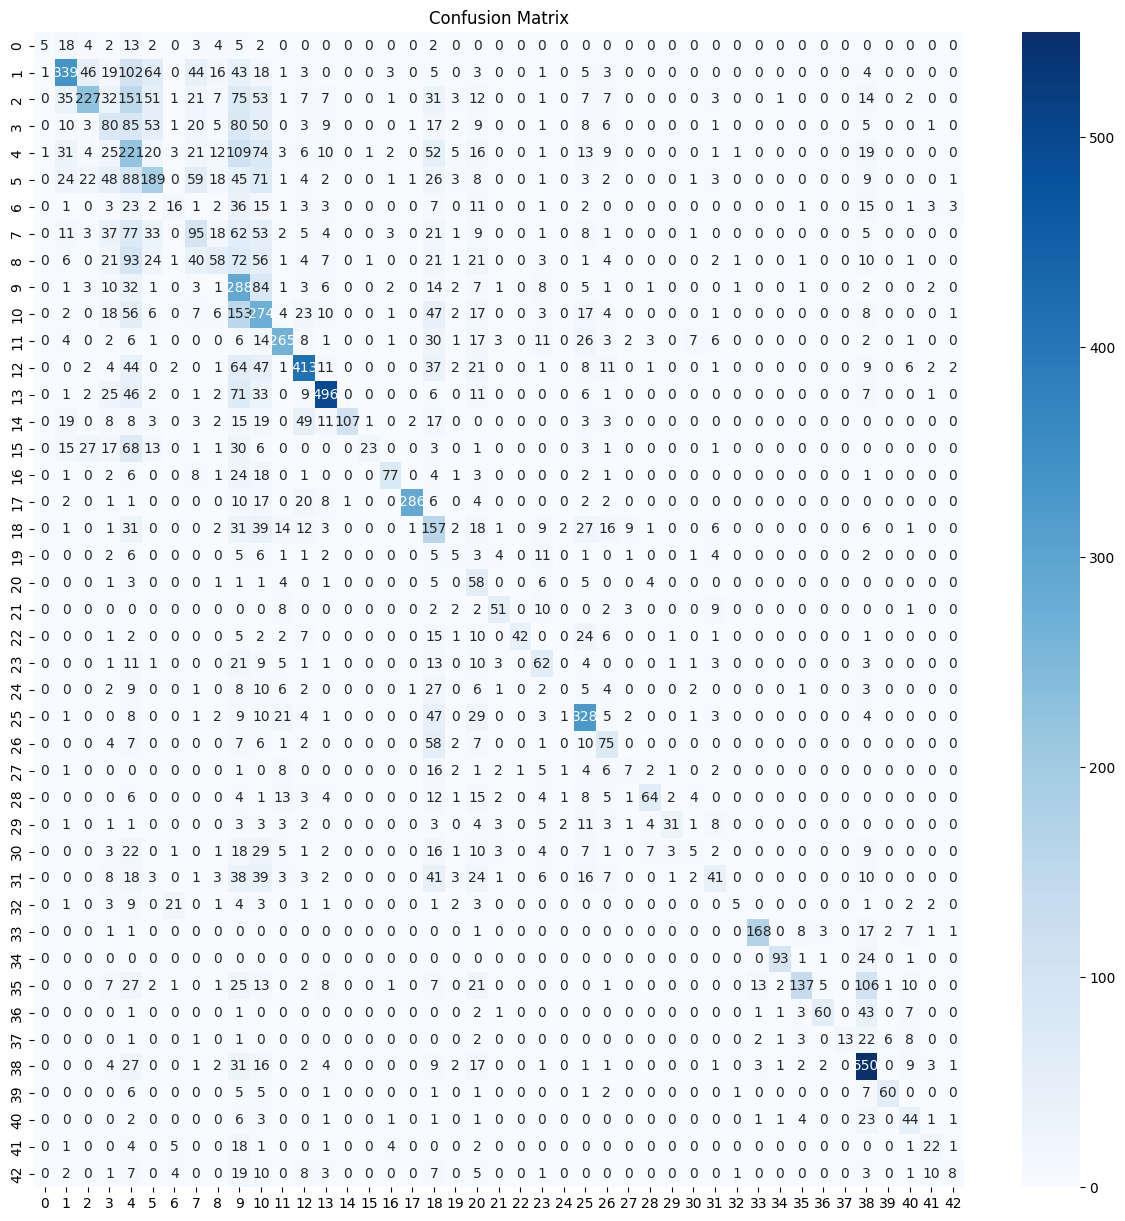

              precision    recall  f1-score   support

           0       0.71      0.08      0.15        60
           1       0.64      0.47      0.54       720
           2       0.66      0.30      0.42       750
           3       0.20      0.18      0.19       450
           4       0.17      0.33      0.22       660
           5       0.40      0.30      0.34       630
           6       0.29      0.11      0.16       150
           7       0.29      0.21      0.24       450
           8       0.35      0.13      0.19       450
           9       0.20      0.60      0.30       480
          10       0.25      0.42      0.31       660
          11       0.71      0.63      0.67       420
          12       0.67      0.60      0.63       690
          13       0.80      0.69      0.74       720
          14       0.99      0.40      0.57       270
          15       0.88      0.11      0.19       210
          16       0.79      0.51      0.62       150
          17       0.98    

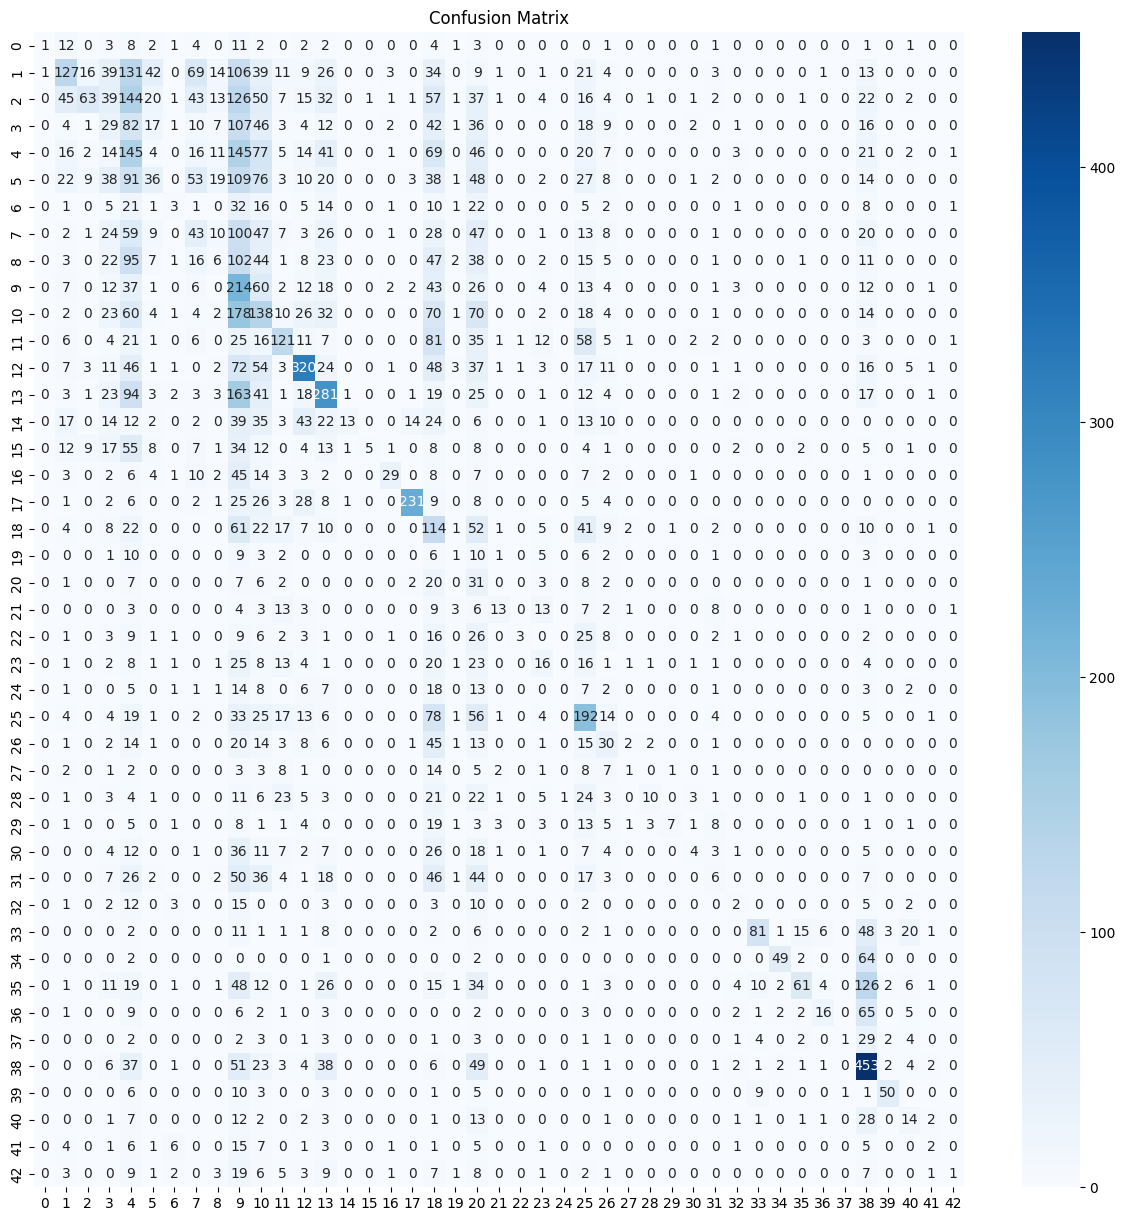

              precision    recall  f1-score   support

           0       0.50      0.02      0.03        60
           1       0.40      0.18      0.24       720
           2       0.60      0.08      0.15       750
           3       0.08      0.06      0.07       450
           4       0.11      0.22      0.14       660
           5       0.21      0.06      0.09       630
           6       0.10      0.02      0.03       150
           7       0.14      0.10      0.11       450
           8       0.06      0.01      0.02       450
           9       0.10      0.45      0.17       480
          10       0.14      0.21      0.17       660
          11       0.40      0.29      0.33       420
          12       0.53      0.46      0.49       690
          13       0.37      0.39      0.38       720
          14       0.81      0.05      0.09       270
          15       0.83      0.02      0.05       210
          16       0.64      0.19      0.30       150
          17       0.91    

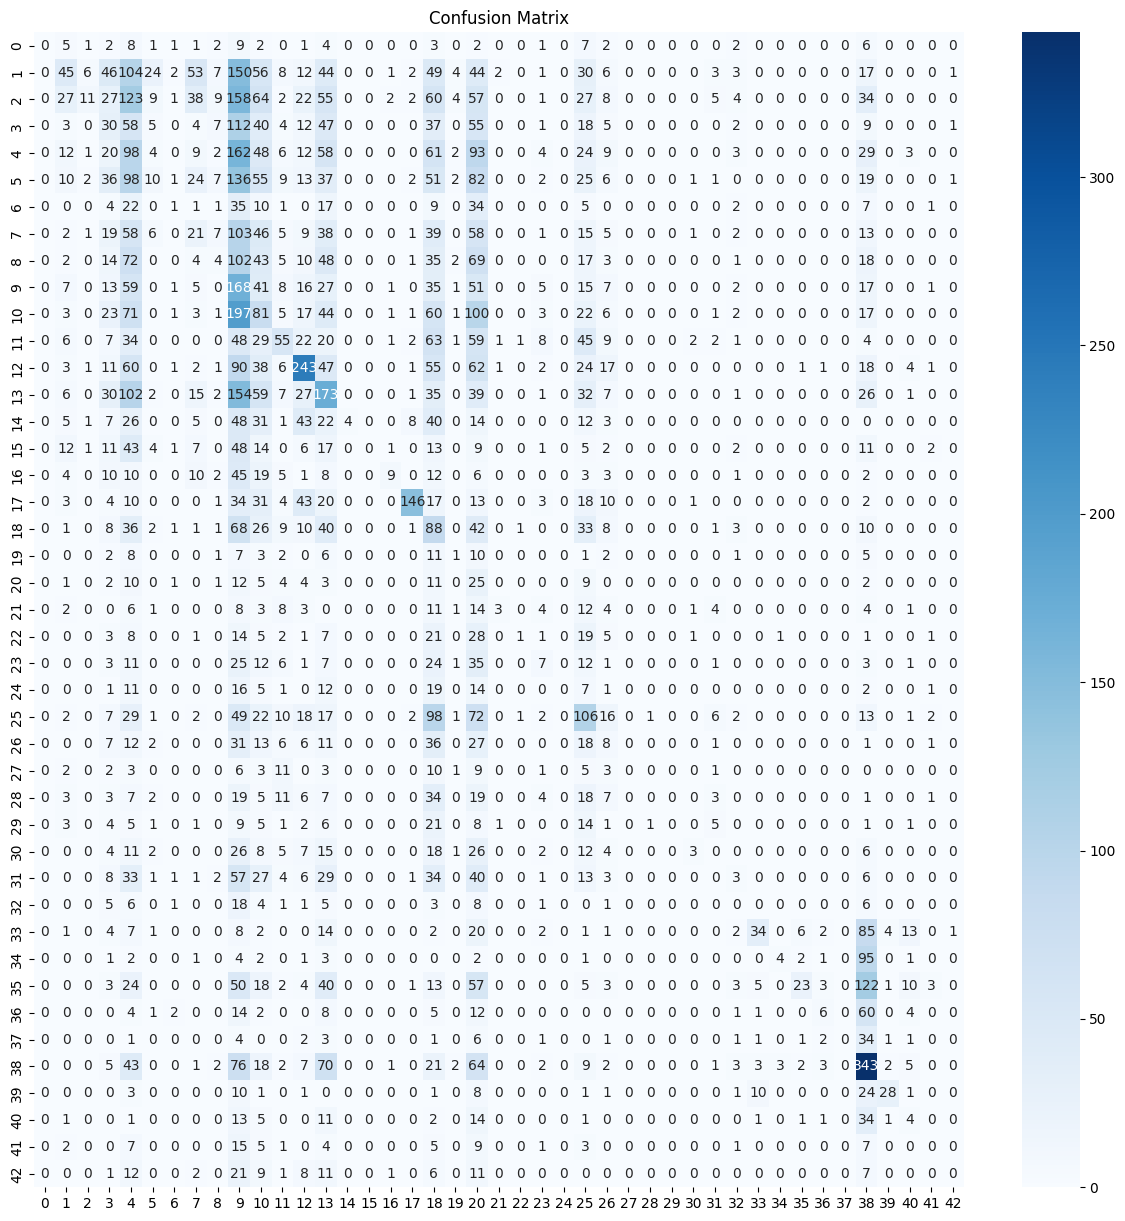

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.26      0.06      0.10       720
           2       0.44      0.01      0.03       750
           3       0.08      0.07      0.07       450
           4       0.07      0.15      0.10       660
           5       0.13      0.02      0.03       630
           6       0.06      0.01      0.01       150
           7       0.10      0.05      0.06       450
           8       0.07      0.01      0.02       450
           9       0.07      0.35      0.12       480
          10       0.09      0.12      0.10       660
          11       0.25      0.13      0.17       420
          12       0.41      0.35      0.38       690
          13       0.16      0.24      0.19       720
          14       1.00      0.01      0.03       270
          15       0.00      0.00      0.00       210
          16       0.50      0.06      0.11       150
          17       0.85    

C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Ester\WORK\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


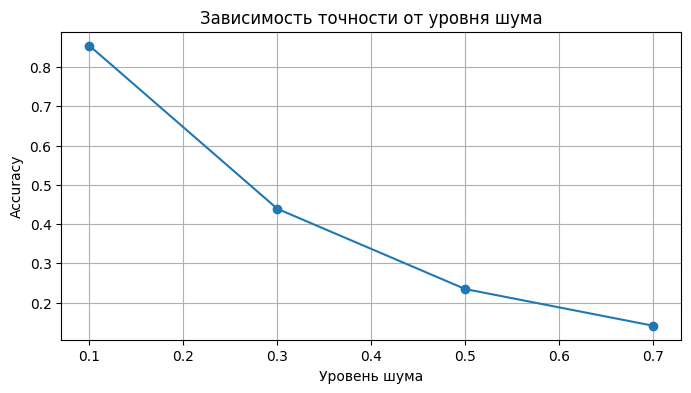

In [45]:
# 24. Дополнительный анализ для разных уровней шума
print("\nАнализ устойчивости к разным уровням шума:")
noise_levels = [0.1, 0.3, 0.5, 0.7]
noise_results = []

for level in noise_levels:
    X_test_noisy_level = add_noise(X_test, noise_factor=level)
    acc, _, _ = evaluate_model(improved_model, X_test_noisy_level, y_test)
    noise_results.append(acc)
    print(f"Noise level {level}: Accuracy = {acc:.2%}")

# Визуализация зависимости accuracy от уровня шума
plt.figure(figsize=(8, 4))
plt.plot(noise_levels, noise_results, marker='o')
plt.xlabel('Уровень шума')
plt.ylabel('Accuracy')
plt.title('Зависимость точности от уровня шума')
plt.grid(True)
plt.show()

In [41]:
#  Gradio-интерфейс
!pip install gradio
import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

   ---------------------------------------- 0.0/59.6 MB ? eta -:--:--
   ---------------------------------------- 0.3/59.6 MB ? eta -:--:--
    --------------------------------------- 0.8/59.6 MB 2.8 MB/s eta 0:00:22
    --------------------------------------- 1.3/59.6 MB 2.4 MB/s eta 0:00:25
   - -------------------------------------- 1.6/59.6 MB 2.2 MB/s eta 0:00:27
   - -------------------------------------- 1.8/59.6 MB 1.8 MB/s eta 0:00:32
   - -------------------------------------- 1.8/59.6 MB 1.8 MB/s eta 0:00:32
   - -------------------------------------- 1.8/59.6 MB 1.8 MB/s eta 0:00:32
   - -------------------------------------- 1.8/59.6 MB 1.8 MB/s eta 0:00:32
   - -------------------------------------- 2.1/59.6 MB 1.2 MB/s eta 0:00:49
   - -------------------------------------- 2.1/59.6 MB 1.2 MB/s eta 0:00:49
   - -------------------------------------- 2.1/59.6 MB 1.2 MB/s eta 0:00:49
   - -------------------------------------- 2.1/59.6 MB 1.2 MB/s eta 0:00:49
   - --------

In [43]:
# Загрузка модели
from tensorflow.keras.models import load_model
model_path = r"C:\Ester\improved_traffic_sign_model.keras"
improved_model = load_model(model_path)

In [44]:
# Предобработка изображения
def preprocess_image(image):
    image = image.resize((32, 32))  # resize
    image = np.array(image) / 255.0  # normalize
    if image.ndim == 2:  # grayscale
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[-1] == 4:  # RGBA
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    return image

In [45]:
# Предсказание и отображение вероятностей
def predict(image):
    image_processed = preprocess_image(image)
    probabilities = improved_model.predict(image_processed)[0]
    predicted_class = int(np.argmax(probabilities))
    
    # Бар-плот вероятностей
    fig, ax = plt.subplots()
    ax.bar(range(len(probabilities)), probabilities, color='skyblue')
    ax.set_xlabel('Класс')
    ax.set_ylabel('Вероятность')
    ax.set_title('Вероятности по классам')
    plt.tight_layout()

    return f"Предсказанный класс: {predicted_class}", fig

In [46]:
# Gradio интерфейс
gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=["text", "plot"],
    title="Классификация дорожных знаков",
    description="Загрузите изображение 32x32, и модель предскажет класс с вероятностями"
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
